## Setup and Intro


This worksheet assumes you are already familiar with at least the basics of using Python and the IPython/Jupyter notebook. It may help to have at least glanced through the "Getting Started" notebook. 

**First step: From the "Cell" menu above, select "All Output", then "Clear"**. 

This will clear out all the output from this notebook and let you run it step-by-step yourself.

Next is some basic setup and imports:

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0)  # bigger plots by default. Adjust as desired
import numpy as np
import poppy
import gpipsfs

Populating the interactive namespace from numpy and matplotlib


# Building up to the GPI Coronagraphic PSF

Let's begin by creating a GPI simulator object, and making a direct mode (non-coronagraphic) PSF:

In [2]:
gpi = gpipsfs.GPI(npix=512, satspots=False, lyot_tabs=False, display_before=True)

For now we keep things simple and turn **off** the satellite spots and the bad-actuator masking tabs in this simulation (we'll add them back in later).  We then turn **on** an option for displaying before and after the occulter and Lyot planes (instead of the default which is just to show after).  

We also decrease the number of pixels used for the pupil to (512,512) instead of the default (1024,1024) just to make things run a bit faster. This limits PSF fidelity and increases aliasing of high frequencies, so it's not ideal in general, but it's an OK tradeoff for rough or preliminary calculations like this. 

Now let's make a simple direct mode PSF at a single wavelength. Feel free to change around the below options if you would like to experiment with another filter or wavelength. 

By setting the `verbose` option to `calcPSF`, we can get a printout of how much light remains after each step of the optical system, along with the display of the wavefront after each optic. 

after Gemini South Primary,              total intensity = 1
after GPI Apodizer CLEAR,                total intensity = 1
after Before FPM,                        total intensity = 1
after GPI FPM SCIENCE,                   total intensity = 1
after Before Lyot,                       total intensity = 1
after GPI Lyot Open,                     total intensity = 1
before GPI lenslet array,                total intensity = 0.991


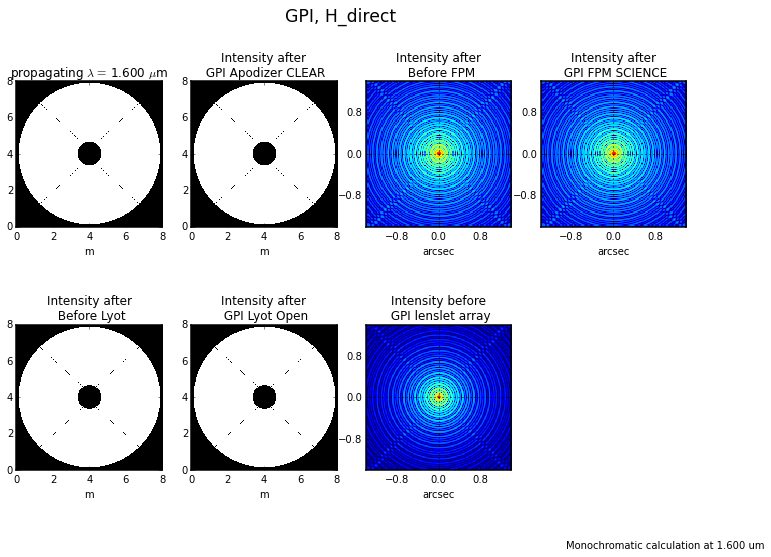

In [3]:
gpi.obsmode ='H_direct'
wavelen = 1.6e-6  # wavelength is always given in meters
psf_direct= gpi.calcPSF(wavelength=wavelen, display=True, verbose=True)  

(_You may note the intermediate focal planes and final focal planes above don't look precisely identical; this is mostly just a display issue because the intermediate planes aren't resampled onto the 14.1 mas/lenslet scale like the final focal plane is._)

First step in blocking star light: let's add a circular coronagraph occulter, all by itself:

after Gemini South Primary,              total intensity = 1
after GPI Apodizer CLEAR,                total intensity = 1
after Before FPM,                        total intensity = 1
after GPI FPM H,                         total intensity = 0.0935
after Before Lyot,                       total intensity = 0.0935
after GPI Lyot Open,                     total intensity = 0.0767
before GPI lenslet array,                total intensity = 0.0668


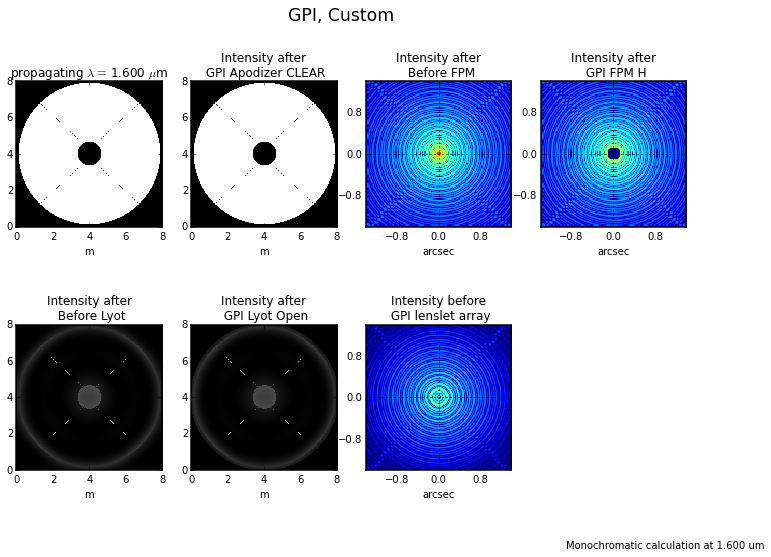

In [4]:
gpi.occulter="H"
psf= gpi.calcPSF(wavelength=wavelen, display=True, verbose=True)

Look at where the remaining light is in the Lyot plane: lots of residual at the edges, center, and secondary supports. 

Let's try to block that by adding a Lyot stop: 

after Gemini South Primary,              total intensity = 1
after GPI Apodizer CLEAR,                total intensity = 1
after Before FPM,                        total intensity = 1
after GPI FPM H,                         total intensity = 0.0935
after Before Lyot,                       total intensity = 0.0935
after GPI Lyot 080m12_04,                total intensity = 0.03
before GPI lenslet array,                total intensity = 0.0286


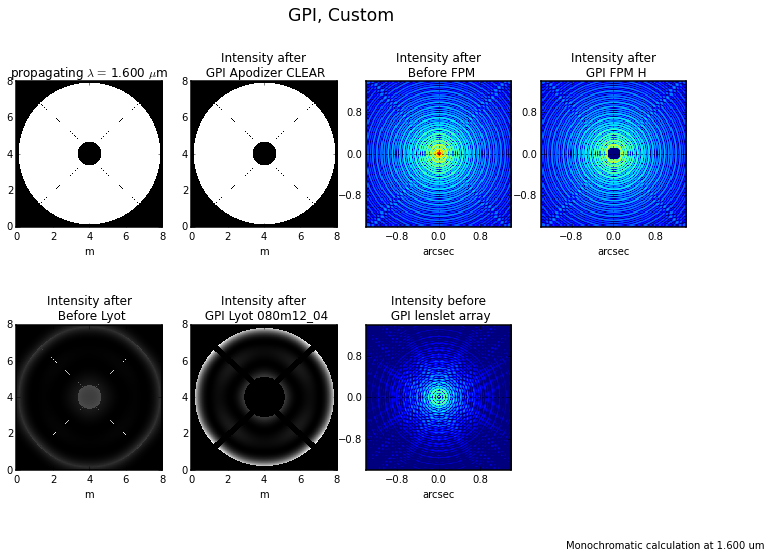

In [5]:
gpi.lyotmask="080m12_04"  # this happens to be the part number for the mask used in H. 
psf= gpi.calcPSF(wavelength=wavelen, display=True, verbose=True)

Look at the PSFs, and also check the output text to see how much more the starlight was reduced. That worked pretty well. 

_(Note that each image is scaled independently for display, and the min/max for the after Lyot mask image is quite different than for the image just before!)_

We can block even more light by using a Lyot mask which is more aggressively undersized:

after Gemini South Primary,              total intensity = 1
after GPI Apodizer CLEAR,                total intensity = 1
after Before FPM,                        total intensity = 1
after GPI FPM H,                         total intensity = 0.0935
after Before Lyot,                       total intensity = 0.0935
after GPI Lyot 080m12_10,                total intensity = 0.0063
before GPI lenslet array,                total intensity = 0.00596


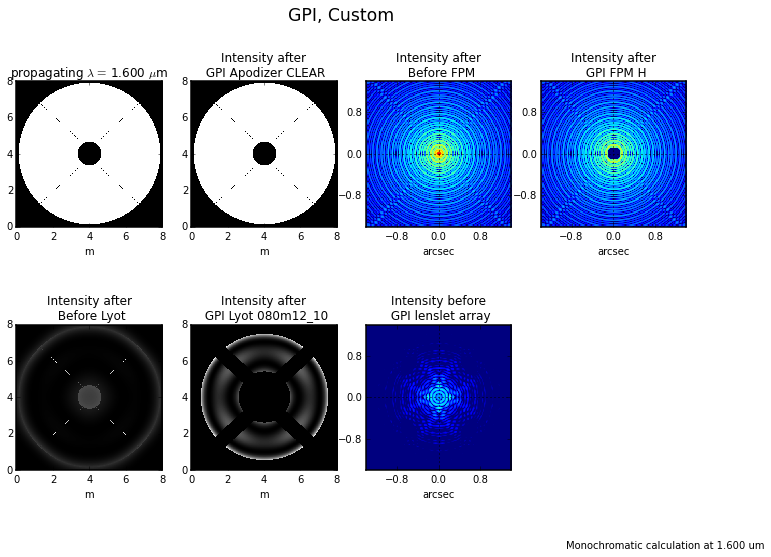

In [6]:
gpi.lyotmask="080m12_10" 
psf= gpi.calcPSF(monochromatic=wavelen, display=True, verbose=True)

That works as expected (but comes at a cost in lower throughput for off axis sources, so it's not ideal').

Let's try something different: an apodizer. First we will try one all by itself. 

after Gemini South Primary,              total intensity = 1
after GPI Apodizer H,                    total intensity = 0.462
after Before FPM,                        total intensity = 0.462
after GPI FPM SCIENCE,                   total intensity = 0.462
after Before Lyot,                       total intensity = 0.462
after GPI Lyot Open,                     total intensity = 0.462
before GPI lenslet array,                total intensity = 0.46


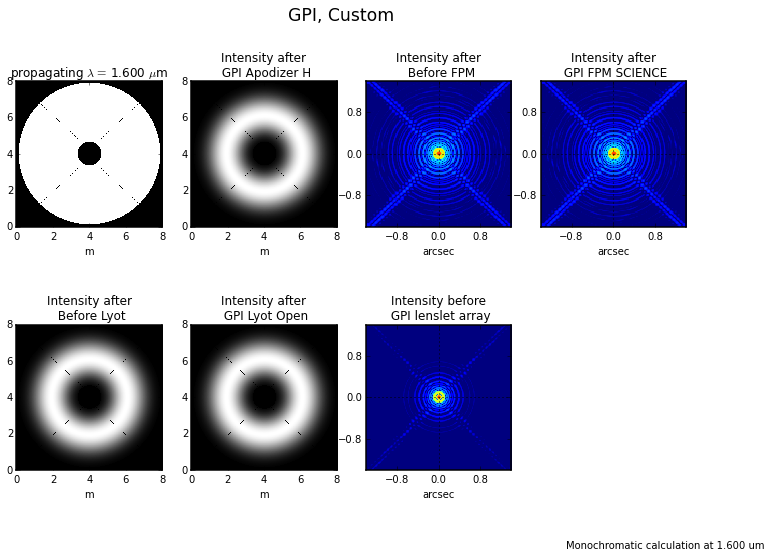

In [7]:
gpi.lyotmask='Open'  
gpi.occulter='SCIENCE' 
gpi.apodizer="H" 
psf= gpi.calcPSF(wavelength=wavelen, display=True, verbose=True)

The apodizer all by itself strongly attenuates most of the Airy rings. About half the starlight remains, but it's all concentrated pretty close to the middle. 

Now let's add the occulter back in:

after Gemini South Primary,              total intensity = 1
after GPI Apodizer H,                    total intensity = 0.462
after Before FPM,                        total intensity = 0.462
after GPI FPM H,                         total intensity = 0.00287
after Before Lyot,                       total intensity = 0.00287
after GPI Lyot Open,                     total intensity = 0.00246
before GPI lenslet array,                total intensity = 0.00101


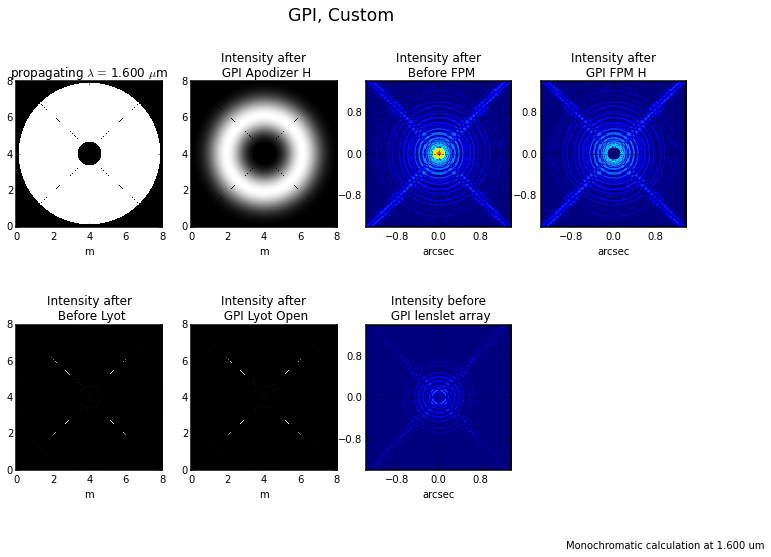

In [8]:
gpi.occulter='H'
psf= gpi.calcPSF(wavelength=wavelen, display=True, verbose=True)

And now we add the Lyot mask. Here at least we've assembled the H_coron mode!

after Gemini South Primary,              total intensity = 1
after GPI Apodizer H,                    total intensity = 0.462
after Before FPM,                        total intensity = 0.462
after GPI FPM H,                         total intensity = 0.00287
after Before Lyot,                       total intensity = 0.00287
after GPI Lyot 080m12_04,                total intensity = 0.000107
before GPI lenslet array,                total intensity = 0.000106


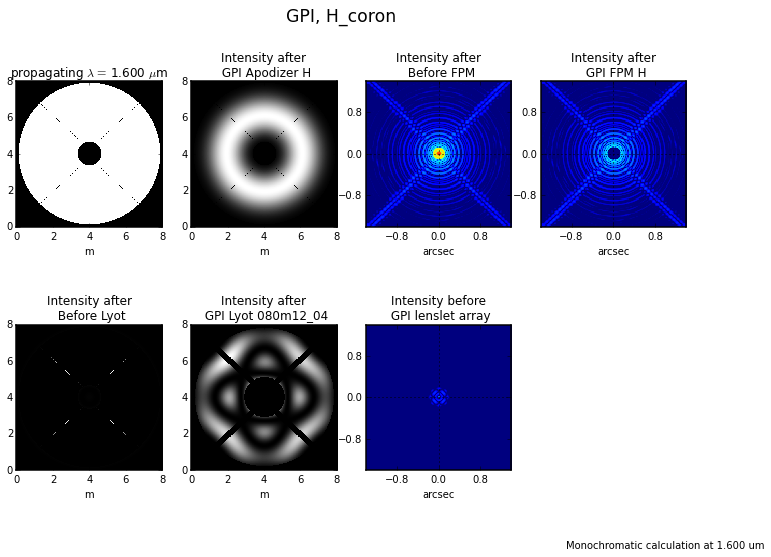

In [9]:
gpi.lyotmask="080m12_04"  
psf= gpi.calcPSF(monochromatic=wavelen, display=True, verbose=True)

Look how much of the star light is blocked now! The stellar PSF is hardly visible in the final image. 

_(What's up with the display after the Lyot mask? The software is automatically rescaling the display min/max, so after the Lyot mask blocks the diffracted light on the secondary supports, you can see the diffuse residual much more.)_

## Satellite Spots, of various types.

Let's turn back on the satellite spots grid in the apodizer model. 

_(Just to be clear, in the real instrument you can't turn this on and off! Grids are printed permantently as part of each of the apodizers.)_

after Gemini South Primary,              total intensity = 1
after GPI Apodizer H,                    total intensity = 0.45
after Before FPM,                        total intensity = 0.45
after GPI FPM H,                         total intensity = 0.00452
after Before Lyot,                       total intensity = 0.00452
after GPI Lyot 080m12_04,                total intensity = 0.0016
before GPI lenslet array,                total intensity = 0.000301


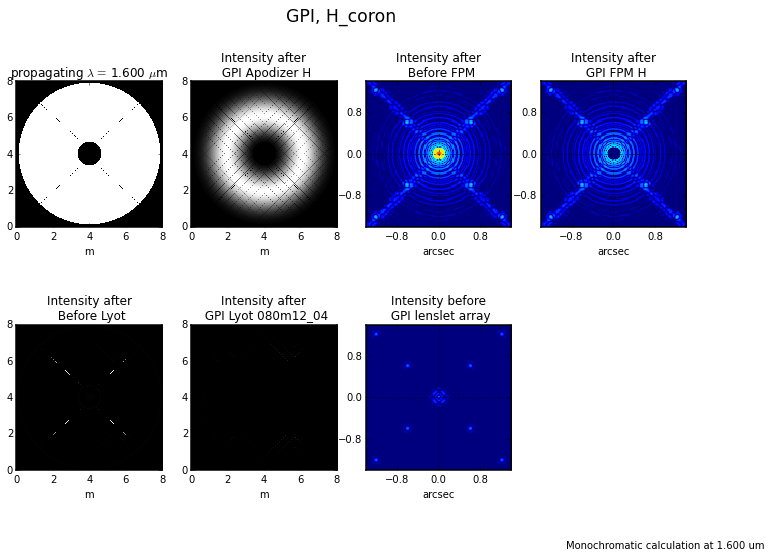

In [10]:
gpi.satspots=True
psf_with_spots = gpi.calcPSF(wavelength=wavelen, display=True, verbose=True)

In practice we see an additional set of spots which is due to the deformable mirror surface print-through.  To see this, we will need to turn on the deformable mirror part of the model. 

_(Disclaimer: This code has only a simplified, imperfect model of the GPI DMs. Don't use this for any work that requires high fidelity AO simulations!)_

We'll turn on the DMs, then display the tweeter surface with a pretty hard stretch. There's about 15 nanometers of grid patterning due to details of the MEMS manufacturing. 

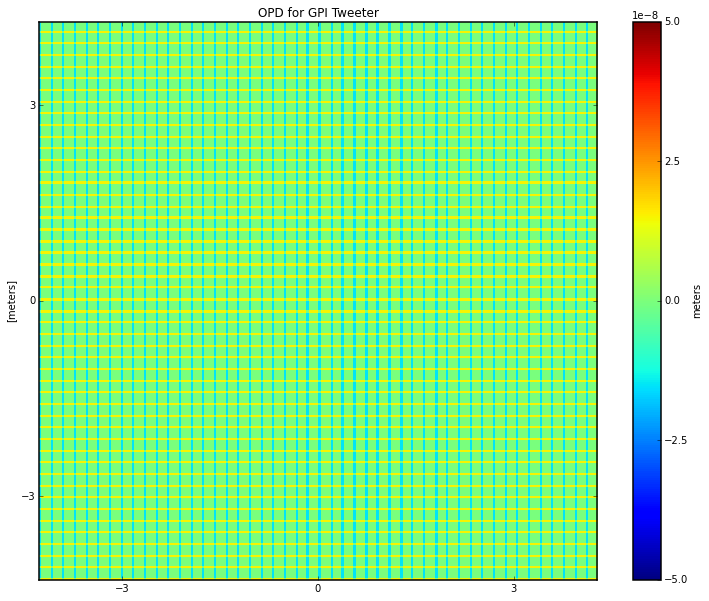

In [11]:
gpi.dms = True

plt.figure(figsize=(13,10))
gpi.tweeter.display(opd_vmax=5e-8, colorbar_orientation='vertical')

Now let's do another optical calculation. Note that now there are some additional pupil planes shown for the two DMs, so let's make the default plot size a bit bigger. 

We do this calculation at a shorter wavelength so we can see the DM spots. 

after Gemini South Primary,              total intensity = 1
after GPI Woofer,                        total intensity = 1
after GPI Tweeter,                       total intensity = 1
after GPI Apodizer H,                    total intensity = 0.45
after Before FPM,                        total intensity = 0.45
after GPI FPM H,                         total intensity = 0.0052
after Before Lyot,                       total intensity = 0.0052
after GPI Lyot 080m12_04,                total intensity = 0.00268
before GPI lenslet array,                total intensity = 0.000863


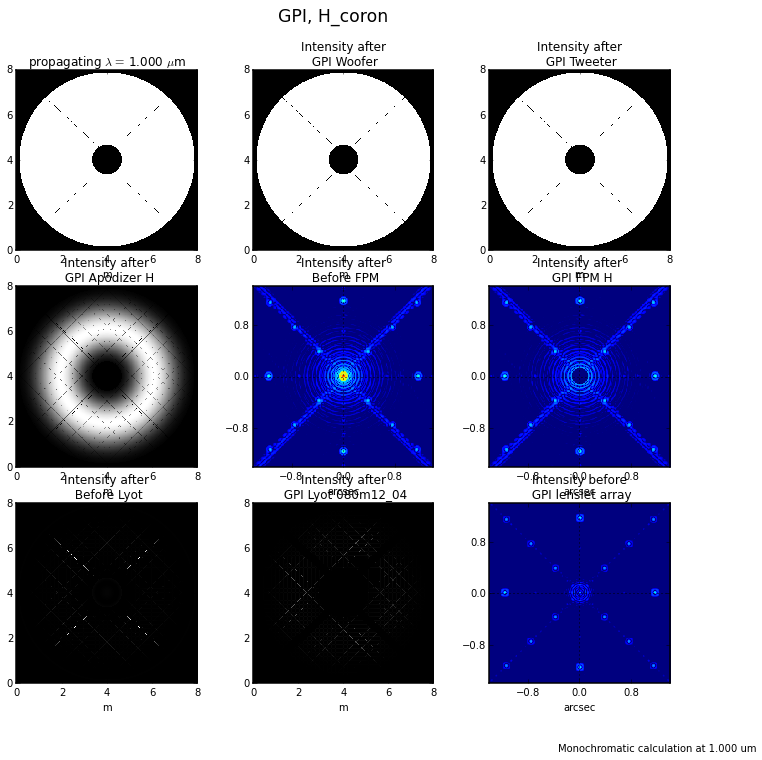

In [12]:
pylab.rcParams['figure.figsize'] = (12.0, 11.0)  # Even bigger plot size now; adjust as desired

psf_with_spots = gpi.calcPSF(wavelength=1e-6, display=True, verbose=True)

That's pretty nice. 

## Bad actuators, and how to hide them

Time to make it less nice!  Bring on the bad actuators.   Where are those?  The model includes a lookup table of the less-than-perfect actuators. 

In [13]:
gpi.tweeter.bad_actuators

[[12, 7, 'DEAD'],
 [41, 15, 'WEAK'],
 [22, 26, 'DEAD'],
 [15, 29, 'WEAK'],
 [1, 39, 'DEAD'],
 [35, 41, 'DEAD']]

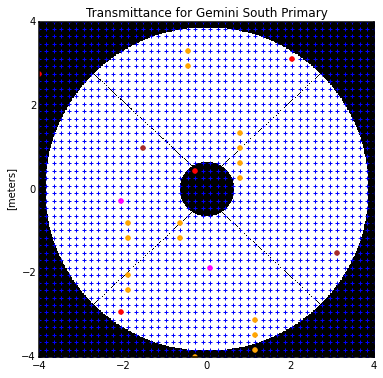

In [14]:
plt.figure(figsize=(8,6))
gpipsfs.GeminiPrimary().display(colorbar=False)
gpi.tweeter.annotate()

# The red and dark red spots show bad (totally dead or very weak) actuators. 
# (magenta are flaky sometimes but generally OK, and 
# yellow are coupled actuator pairs but those are not as big a deal.) 

Let's imagine some of those dead actuators are stuck at large piston values, a few microns away from nominal. (The tweeter DM surface travel is a couple microns so this is plausible.)

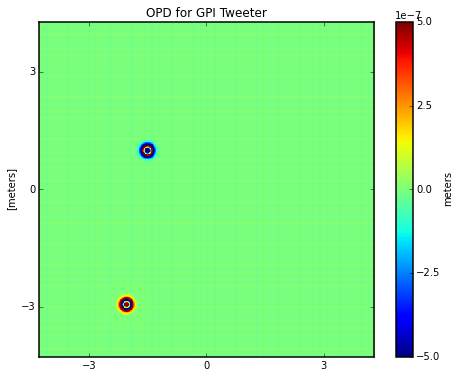

In [15]:
gpi.tweeter.set_actuator(12,7,   3000)  # actuator positions given in nanometers
gpi.tweeter.set_actuator(15,29, -3000)  # actuator positions given in nanometers


plt.figure(figsize=(8,6))
gpi.tweeter.display(colorbar_orientation='vertical')

after Gemini South Primary,              total intensity = 1
after GPI Woofer,                        total intensity = 1
after GPI Tweeter,                       total intensity = 1
after GPI Apodizer H,                    total intensity = 0.45
after Before FPM,                        total intensity = 0.45
after GPI FPM H,                         total intensity = 0.0119
after Before Lyot,                       total intensity = 0.0119
after GPI Lyot 080m12_04,                total intensity = 0.00933
before GPI lenslet array,                total intensity = 0.00509


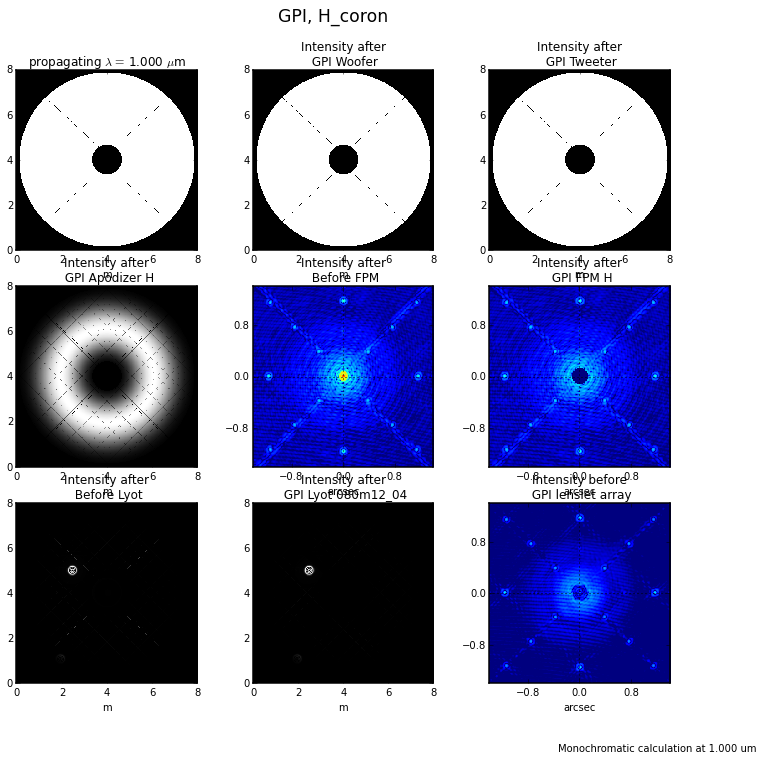

In [16]:
psf_badact = gpi.calcPSF(wavelength=1e-6, display=True, verbose=True)

Yuuuuuck.

_(Fourier optics homework: Think about why the pattern of all that junky extra light that makes through the coronagraph has the particular apperance that it does.)_

Time for Lyot stop blocking tabs to the rescue!

after Gemini South Primary,              total intensity = 1
after GPI Woofer,                        total intensity = 1
after GPI Tweeter,                       total intensity = 1
after GPI Apodizer H,                    total intensity = 0.45
after Before FPM,                        total intensity = 0.45
after GPI FPM H,                         total intensity = 0.0119
after Before Lyot,                       total intensity = 0.0119
after GPI Lyot 080m12_04,                total intensity = 0.00302
before GPI lenslet array,                total intensity = 0.00123


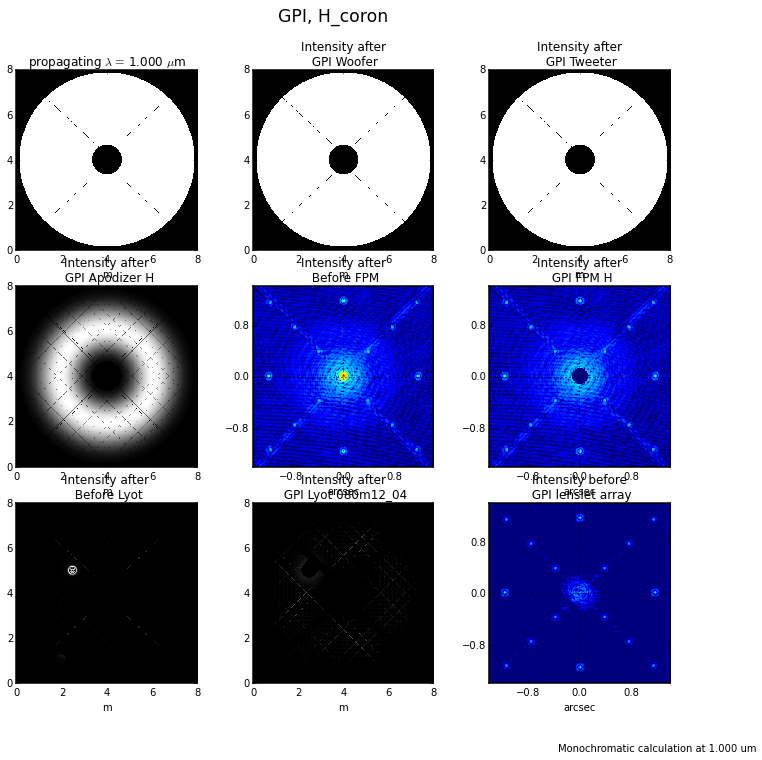

In [17]:
gpi.lyot_tabs = True
psf_blocked = gpi.calcPSF(wavelength=1e-6, display=True, verbose=True)

## Normalizing to Contrast Units

Be aware that the outputs of this simulation code are *not* in the contrast units you might hope for. They're actually in "fraction of the total intensity in the entrance pupil that makes it to that pixel of the PSF" units. 

If you want to get results in contrast units, you should: 

  - Calculate your desired coronagraphic PSF
  - Calculate an appropriate unocculted PSF (e.g. in an `_unblocked_` obsmode)
  - Measure the intensity in the central peak pixel of the unocculted PSF. 
  - Divide the coronagraphic PSF by this amount. 
  
Left as an exercise for the reader. :-)